# [ep13] Movielens 영화 추천하기
머신러닝에서 가장 상업적으로 성공적인 추천시스템에 대해 알아보자.
유튜브,넷플릭스, 쇼핑사이트에서 이미 우리에게 다양한 추천을 해주고 있습니다. SNS에서도 친구추천 및 추천 피드가 올라옵니다.

추천 시스템의 원리는 '나와 비슷한 다른 사용자가 좋아하는 것과 비슷한 것을 내게 추천해준다'는 것이다.

## 실습 목표
- 추천 시스템의 개념과 목적을 이해
- Implicit 라이브러리를 활용한 Matrix Factorization 기반의 추천 모델을 만든다.
- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해준다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다.
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.
- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

## 실습 목차
1. 추천 시스템이란 게 뭔가요?
2. 데이터 탐색하기와 전처리
3. 사용자의 명시적/암묵적 평가
4. Matrix Factorization(MF)
5. CSR(compressed Sparse Row) Matrix
6. MF 모델 학습하기
7. 비슷한 아티스트 찾기 + 유저에게 추천하기
8. 프로젝트 - MovieLens 영화 추천 실습

# 1. 추천 시스템이란 게 뭔가요?
온라인 콘텐츠 서비스에서 데이터 분석과 AI 기술을 접목한 추천 시스템의 활용은 이제 선택이 아닌 필수다.
음원 스트리밍 서비스에서 얼마나 좋은 플레이리스트를 만들어주는 지가 서비스 선택요소가 되고 있다.

## 추천 알고리즘
사용자가 선호할 만한 아이템을 추천하기 위한 기본적인 알고리즘으로 콘텐츠 기반 필터링과 협업 필터링이 있다.

## 콘텐츠 기반 필터링
콘텐츠(아이템)의 특성과 사용자의 선호도를 비교해 추천해준다.
- 많이 듣는 음악의 장르
- 많이 듣는 가수
- 많이 사는 브랜드
- 많이 사는 품목

### 장점
- 다른 사용자의 데이터가 없어도 가능하다.
- 추천하는 아이템의 범위가 넓다.
- 추천 이유를 이해하기 쉽다.

### 단점
- 범위가 커서 적절한 특징을 찾기 어렵다.
- 새로운 사용자에게 추천하기 어렵다.
- 선호하는 특성을 가진 항목을 반복 추천한다.

## 협업 필터링
협업 필터링은 특정 집단에서 발생하는 '유사한 사용행동'을 파악하여, 비슷한 성향의 사람들에게 아이템을 추천하는 기술이다.

### 사용자 기반 협업 필터링
나와 성향이 비슷한 집단이 사용한 아이템을 추천해주는 방식

### 아이템 기반 협업 필터링
내가 구매하려는 물품과 함께 구매되는 아이템을 추천해주는 방식

### 협업 필터링의 제약 상황
- 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황
- 계산량이 너무 많아 추천의 효율이 떨어지는 상황
- 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황

## 유튜브 뮤직이 초기 사용자에게 좋아하는 아티스트 5명 이상의 정보를 요구하는 이유
- 음원서비스를 처음 가입해서 사용하면, 사용자 기반 협업필터링을 하기 위해서, 나와 성향이 비슷한 집단을 찾아줘야 한다.
- 또한 내가 좋아하는 아티스트를 기반으로 아이템 기반 협업 필터링도 할 수 있다.
- 처음에 이러한 추천을 하지 않으면, 처음 무작위로 추천 시스템에 빠지기 쉬운 필터 버블이 발생할 수 있다. 이는 추천의 다양성을 저해하여, 적합한 추천시스템이 작동되기 어려울 수 있다.

## 추천 시스템의 선행 조건
- 아이템이 많고
- 유저의 취향이 다양할 때

# 2. 데이터 탐색하기와 전처리
## 데이터 준비
[Last.fm에서 제공하는 사용자 기반 아티스트 노래 재생 데이터](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html)를 가지고 추천 시스템을 만들어보자.

여기서 제공하는 데이터는 기존의 csv와 다른 tsv 파일이다. 하지만 기존의 pd.read_csv로 열어볼 수 있다.

In [1]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


 4개의 항목은 각각 User ID, Artist MBID, Artist Name, Play횟수 로 보입니다.
 
 여기서 필요없는 artist_MBID는 제거하자.

In [2]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [3]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [4]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


## 데이터 탐색
추천 모델을 만들기 전에 데이터의 기본적인 정보를 보고 갑시다.
- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값에 대한 통계

In [5]:
# 유저 수
data['user_id'].nunique()

358868

In [6]:
# 아티스트 수
data['artist'].nunique()

291346

In [7]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [8]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [9]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

## 모델 검증을 위한 사용자 초기 정보 세팅

- 좋아하는 아티스트를 5명을 입력하자
- 위의 아티스트의 음악을 30회 씩 들은 user_id : zimin을 만들고
- 데이터를 넣어준다.

In [10]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


zimin이라는 user_id에 좋아하는 아티스트 노래를 30회씩 들었다고 데이터를 만들었다.

## 모델에 활용하기 위한 전처리(실습)

- user_id와 artist의 string 값을 고유번호들로 인덱싱하자
    - user_id, artist의 고유값을 하나의 딕셔너리로 만들고
    - 각각의 딕셔너리에 대한 키(인덱스), 벨류값(원래값)을 바꿔준다.

In [11]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [12]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


In [13]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


# 3. 사용자의 명시적/암묵적 평가
- 좋아요나 별점처럼 선호도를 명시적(Explicit)으로 표현하는 방식과
- 몇번이나 플레이 했는지 등의 서비스를 자연스럽게 이용하면서 발생한 피드백을 암묵적(Implicit) 평가라 한다.

우리는 이번에 암묵적 평가를 사용하여 추천시스템을 만든다.

## 암묵적 평가의 특징
- 부정적인 피드백이 없다.(No Negative Feedback)
- 애초에 잡음이 많다.(Inherently Noisy)
- 수치는 신뢰도를 의미한다.(The numerical value of implicit feedback indicates confidence)
- Implicit-feedback Recommender System의 평가는 적절한 방법을 고민해봐야 한다.(Evaluation of implicit-- - feedback recommender requires appropriate measures)

## 아티스트의 노래를 1회 재생한 데이터 처리
아티스트의 노래를 1회만 재생한 경우, 우리는 아티스트의 노래가 맘에 들지 않아서 다른 곡들도 들어보지 않았다고 보는 게 좋을것 같다. 그런데 아티스트의 노래를 1회만 재생한 경우는 얼마나 될까?

In [14]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535660
Ratio of only_one over all data is 0.84%


확인해보니, 비중이 0.84%로 적다. 싫어하는 아티스트가 많았을 텐데도, 0.84%는 유의미하진 않아보인다. 덜 좋아한다고 보는게 좋겠다. 재생횟수가 1이던 100이던 그만큼의 가중치를 줘서 아티스트를 좋아한다고 판단하는데 쓰도록 한다.

# 4. Matrix Factorization(MF)

추천 시스템을 만들기 위한 데이터전 처리를 마쳤으니 모델을 만들어보자.

m명의 사용자들이 n명의 아티스트에 대한 암묵적 평가(재생횟수)의 평가행렬을 만드는 것이다.

![평가 매트릭스](https://d3s0tskafalll9.cloudfront.net/media/images/E-3v2-2_ekCv9hW.max-800x600.png)
*[- 출처: CuMF_SGD: Fast and Scalable Matrix Factorization(https://arxiv.org/pdf/1610.05838.pdf)]
*

위의 그림과 같이 비어있는 공간이 많을 것이다. 이런 상황에서 추천 시스템의 모델 중 Matrix Factorization, 행렬 분해 모델을 사용하겠다. 
2006년 넷플릭스가 개최한 경진대회에서 10%의 성능 향상을 시키면서 알려지게 되었습니다. m x n 사이즈의 평가 행렬 R을 m x k의 크기의 행렬 P와 n x k 크기의 행렬 Q의 곱으로 분해하는 것이다.

![평가 행렬 예시](https://d3s0tskafalll9.cloudfront.net/media/images/E-3v2-3.max-800x600.png)
*[출처: https://developers.google.com/machine-learning/recommendation/collaborative/matrix]*

위의 그림에서 행렬 P는 사용자의 특성 백터이며, 행렬 Q는 영화의 특성 백터이다.

이처럼 모델의 목표는 모든 유저와 콘텐츠에 대해 k-차원의 백터를 잘 만들어 내는 것이다.

# 5. CSR(Compressed Sparse Row) Matrix
우리 데이터를 가지고 유저 x 콘텐츠 평가 행렬을 만든다고 하면, 36만 x 29만의 평가행렬이 나오는데 원소에 정수 1개씩만 들어간다고 해도 97GB의 행렬이 만들어진다.

이럴 때 대안으로 쓰일 수 있는 기법이 CSR이다. 희소한 행렬에서 0이 아닌 유효한 데이터로 채워지는 데이터 값과 자표 정보만을 구성하여 메모리 사용량을 최소화 하면서 희소행렬과 동일하게 표현하는 데이터 구조이다.

CSR 행렬은 data, indices, indptr로 행렬을 압축한다.

- data : 0이 아닌 원소를 차례로 기입한 값
- indices : data의 각 요소가 어느 열에 있는지 표현한 index
- indptr : 최초 시작행 번호, 시작행에서의 데이터 개수, 두번 째 행에서의 데이터 누적개수, ..., 마지막행에서의 데이터 ㄴ적개수 로 표현한다.

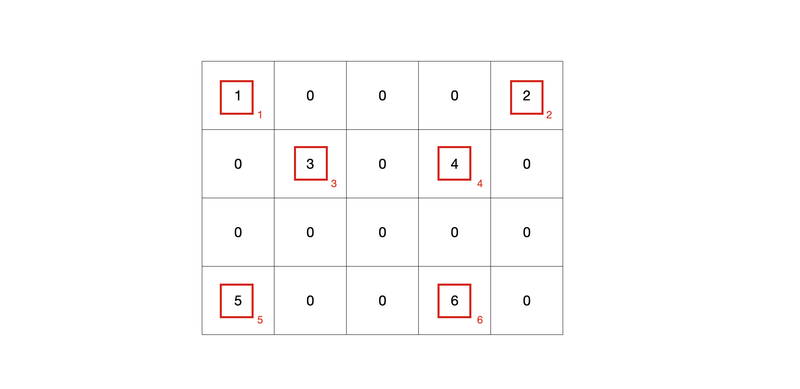

In [15]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Row format>

# 6. MF 모델 학습하기
이전 스텝에서 설명한 MF 모델을 implicit 패키지를 사용해서 학습한다.
- implicit 패키지는 이전에 설명한 암묵적 평가를 가진 dataset을 사용하는 다양한 모델을 빠르게 학습할 수 있는 패키지
- 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용한다.
- MF로 평가행렬 R을 행렬 P와 Q로 쪼개는데, 한쪽을 고정시키면서 다른 쪽을 학습시켜 효과적인 방법이다.

In [16]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지


*1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.*

In [17]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [18]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [19]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

모델 학습이 끝났다.
- Zimin 벡터와 black eyed peas의 벡터를 어떻게 만들고 있는지
- 두 벡터를 곱하면 어떤 값이 나오는지
확인해보자.

In [20]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [21]:
zimin_vector

array([ 0.88891447,  0.16307971,  0.9266715 ,  0.23731394, -0.22952583,
        0.30566376,  1.2462927 , -0.3760544 ,  0.7066723 , -0.7145912 ,
       -0.4006348 ,  0.16823557,  0.2429949 ,  0.7159164 ,  0.81458426,
       -0.37885076, -0.37382832, -0.41247037,  0.27372834,  0.51652247,
       -0.43557492,  0.903353  ,  0.12484943, -0.77665293,  0.04850851,
       -1.5006845 , -0.04757697,  0.5592844 , -0.59336406,  0.17625917,
        0.08125752,  0.7695811 ,  0.03228325, -0.88131195, -0.02481452,
        0.70933145, -0.3239725 , -0.60929716, -1.5211945 , -0.03775948,
        0.14693426, -0.09015303,  0.36429134, -0.6746695 ,  0.00355758,
        0.9510489 ,  1.4164021 ,  0.32833216,  0.38887602,  0.4934235 ,
       -1.5585611 , -0.77541465, -1.4493746 ,  0.02224746, -1.2391893 ,
       -0.3931995 ,  0.19615601, -0.30308294,  0.23135568, -0.10334405,
       -0.85329777, -0.47014827, -0.459516  , -0.10069439,  0.77564615,
        0.54945755,  1.3266948 ,  0.51586825,  0.06784485, -0.76

In [22]:
black_eyed_peas_vector

array([ 0.01587754,  0.02331992,  0.01390264,  0.01763332,  0.00396509,
        0.01965313,  0.01534428,  0.01680305,  0.02201631,  0.00075318,
       -0.00647622,  0.00433152,  0.02029246,  0.01776273,  0.00323227,
        0.0194697 , -0.01332787, -0.00560384,  0.01439178,  0.01886999,
        0.00440032,  0.01938619,  0.00533741, -0.01442128, -0.0021319 ,
       -0.01046278,  0.00942493,  0.01493938,  0.0041553 ,  0.00250965,
        0.01310749,  0.0225809 ,  0.01724635, -0.00095679,  0.00615438,
        0.01709703,  0.01271611, -0.01453998, -0.01606601,  0.00786458,
        0.00801575,  0.01023994,  0.0104235 , -0.00347278,  0.00290741,
        0.02580377,  0.01414636,  0.00716304,  0.0040894 ,  0.00869061,
       -0.02101251, -0.0005189 , -0.00059862,  0.00904085, -0.02367277,
       -0.0027849 , -0.00248029,  0.00562694,  0.02135961, -0.00556614,
       -0.0043109 ,  0.00866824,  0.00234416,  0.00249796, -0.00249685,
        0.01411621,  0.03349173,  0.00754551, -0.00465161,  0.00

In [23]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.518622

선호할 거 같은 zimin과 black_eyed_peas가 1이 나올 거 같은데 0.49밖에 안나왔다. 반복횟수를 늘려야할까하지만 먼저 학습하지 않은 새로운 queen과의 선호도도 살펴보자.

In [24]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.31074962

# 7. 비슷한 아티스트 찾기 + 유저에게 추천하기
## 비슷한 아티스트 찾기

als 클래스에 구현된 similar_items 메서드를 통해서 비슷한 아티스트를 찾아보자.

In [25]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 1.0),
 (277, 0.985315),
 (28, 0.97939396),
 (5, 0.97213095),
 (490, 0.9692245),
 (473, 0.9683817),
 (217, 0.9680223),
 (247, 0.9605957),
 (418, 0.96002036),
 (1018, 0.9449473),
 (55, 0.94334364),
 (694, 0.94313836),
 (910, 0.9385287),
 (268, 0.93613565),
 (782, 0.9351769)]

아티스트의 id와 유사도를 튜플로 반환하고 있다. id를 다시 이름으로 매핑시켜주자.

In [26]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'oasis',
 'placebo',
 'radiohead',
 'the beatles',
 'u2',
 'the smashing pumpkins',
 'arctic monkeys',
 'foo fighters',
 'nirvana',
 'pink floyd',
 'the white stripes']

여러 가수들을 찾기 위해 함수를 만들어서 반복하자.

In [27]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


In [28]:
get_similar_artist('2pac')

['2pac',
 '50 cent',
 'nas',
 'dr. dre',
 'notorious b.i.g.',
 'snoop dogg',
 'the game',
 'ludacris',
 'jay-z',
 'dmx']

In [29]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'gwen stefani',
 'justin timberlake',
 'leona lewis']

## 유저에게 아티스트 추천하기
als 클래스에 구현된 recommend 메서드를 통해서 제가 좋아할 만한 아티스트를 추천받는다.
filter_already_liked_items는 사용자가 이미 평가한 아이템은 제외하는 argument이다.

In [30]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(350, 0.439452),
 (369, 0.4318928),
 (627, 0.42402917),
 (550, 0.4189758),
 (1800, 0.41014904),
 (274, 0.39132425),
 (901, 0.38119435),
 (391, 0.37769857),
 (2249, 0.37517226),
 (355, 0.36810526),
 (618, 0.36677536),
 (409, 0.35508555),
 (621, 0.35155594),
 (382, 0.3493346),
 (354, 0.34640908),
 (5555, 0.34584796),
 (5, 0.34374923),
 (2902, 0.34268707),
 (564, 0.3414269),
 (637, 0.34057552)]

In [31]:
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'justin timberlake',
 'maroon 5',
 'britney spears',
 'lady gaga',
 'michael jackson',
 'pink',
 'christina aguilera',
 'katy perry',
 'madonna',
 'the pussycat dolls',
 'amy winehouse',
 'alicia keys',
 'mika',
 'nelly furtado',
 'timbaland',
 'red hot chili peppers',
 'james blunt',
 'kanye west',
 'akon']

리한나를 추천해줬는데, als클래스에 구현된 explain 메서드를 사용하면 기록남 긴 데이터 중 추천에 깅여한 정도를 확인할 수 있다.

In [32]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [33]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.21205758725171023),
 ('black eyed peas', 0.13394388937969184),
 ('jason mraz', 0.05152743615606807),
 ('coldplay', 0.04368667954528573),
 ('maroon5', 0.0006643655279623795)]

비욘세와 블랙아이드피스가 크게 기여했다. 마룬5는 recommend 모델에서 파라미터 filter_already_liked_items=True로 했는데 마룬파이브가 이미 평가한 아이템으로 나온것으로 implicit 0.4.2에서 생긴 버그이다

# 8. 프로젝트 - Movielens 영화 추천 실습

- MF 모델 학습 방법 기반
- 내가 좋아할 만한 영화 추천 시스템 제작
- MovieLens 1M Dataset 데이터를 활용한다.
- 별점 데이터는 명시적 평가 데이터이지만 암묵적 평가로 테스트 해보자.
    - 별점을 재생횟수라고 해석하며, 3점 미만의 별점은 선호하지 않는다고 가정한다.
    
## 라이브러리 확인

In [34]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


## 1. 데이터 준비와 전처리

Movielens 데이터는 rating.dat안에 이미 인덱싱까지 완료된 사용자-영화-평점이 정리되어 있다.

### 데이터 로드

In [35]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 별점 3점 미만은 선호도 0으로 삭제

In [36]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


83.64%의 데이터가 남았다.

In [37]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [38]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

### 타임스탬프 컬럼 삭제

In [186]:
del ratings['timestamp']

In [39]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## 2. 데이터 분석
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [40]:
ratings['movie_id'].nunique()

3628

In [41]:
ratings['user_id'].nunique()

6039

In [42]:
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

## 3. 내가 선호하는 영화를 5가지 골라서 ratings에 추가

In [43]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [44]:
movies['title']

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
                       ...                
3878               Meet the Parents (2000)
3879            Requiem for a Dream (2000)
3880                      Tigerland (2000)
3881               Two Family House (2000)
3882                 Contender, The (2000)
Name: title, Length: 3883, dtype: object

In [45]:
movies[movies['title'] == 'Toy Story (1995)']

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy


In [48]:
movies[movies['title'].apply(lambda x : 'story' in x) ]

,movie_id,title,genre
2232,2301,History of the World: Part I (1981),Comedy
2260,2329,American History X (1998),Drama


In [49]:
movies[movies['title'].apply(lambda x : 'story' in x.lower()) ]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
124,126,"NeverEnding Story III, The (1994)",Adventure|Children's|Fantasy
292,295,"Pyromaniac's Love Story, A (1995)",Comedy|Romance
833,844,"Story of Xinghua, The (1993)",Drama
865,876,Police Story 4: Project S (Chao ji ji hua) (1993),Action
886,898,"Philadelphia Story, The (1940)",Comedy|Romance
1124,1140,Entertaining Angels: The Dorothy Day Story (1996),Drama
1608,1654,FairyTale: A True Story (1997),Children's|Drama|Fantasy
1728,1787,Paralyzing Fear: The Story of Polio in America...,Documentary
1782,1851,Leather Jacket Love Story (1997),Drama|Romance


In [67]:
movies[movies['title'].apply(lambda x : 'forrest' in x.lower()) ]

,movie_id,title,genre
352,356,Forrest Gump (1994),Comedy|Romance|War


In [113]:
temp_movies = movies.copy()

In [114]:
temp_movies = temp_movies.set_index('movie_id')

In [115]:
temp_movies.head()

,title,genre
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [117]:
del temp_movies['genre']

In [118]:
temp_movies.head()

,title
movie_id,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [122]:
temp_movies.duplicated().value_counts()

False    3883
dtype: int64

중복값이 없다.

In [135]:
temp_movies.tail()

,title
movie_id,
3948,Meet the Parents (2000)
3949,Requiem for a Dream (2000)
3950,Tigerland (2000)
3951,Two Family House (2000)
3952,"Contender, The (2000)"


데이터 길이보다 큰 인덱스인 movie_id를 갖는다. movie_id에 결측치가 있는지 연속적이지 않다.

In [139]:
type(temp_movies)

pandas.core.frame.DataFrame

In [142]:
np_movies = temp_movies.to_numpy()

print(np_movies[:5])

[['Toy Story (1995)']
 ['Jumanji (1995)']
 ['Grumpier Old Men (1995)']
 ['Waiting to Exhale (1995)']
 ['Father of the Bride Part II (1995)']]


In [146]:
temp_movies.head()

,title
movie_id,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [166]:
dict_movies = temp_movies.to_dict()['title']

In [167]:
dict_movies

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (1995)',
 33: 'Wings of Courage (1995)',
 34: 'Babe (1

In [168]:
type(dict_movies)

dict

In [169]:
dict_movies[1]

'Toy Story (1995)'

In [178]:
movie_to_idx = dict([(v,k) for k,v in dict_movies.items()])

In [179]:
movie_to_idx

{'Toy Story (1995)': 1,
 'Jumanji (1995)': 2,
 'Grumpier Old Men (1995)': 3,
 'Waiting to Exhale (1995)': 4,
 'Father of the Bride Part II (1995)': 5,
 'Heat (1995)': 6,
 'Sabrina (1995)': 7,
 'Tom and Huck (1995)': 8,
 'Sudden Death (1995)': 9,
 'GoldenEye (1995)': 10,
 'American President, The (1995)': 11,
 'Dracula: Dead and Loving It (1995)': 12,
 'Balto (1995)': 13,
 'Nixon (1995)': 14,
 'Cutthroat Island (1995)': 15,
 'Casino (1995)': 16,
 'Sense and Sensibility (1995)': 17,
 'Four Rooms (1995)': 18,
 'Ace Ventura: When Nature Calls (1995)': 19,
 'Money Train (1995)': 20,
 'Get Shorty (1995)': 21,
 'Copycat (1995)': 22,
 'Assassins (1995)': 23,
 'Powder (1995)': 24,
 'Leaving Las Vegas (1995)': 25,
 'Othello (1995)': 26,
 'Now and Then (1995)': 27,
 'Persuasion (1995)': 28,
 'City of Lost Children, The (1995)': 29,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 30,
 'Dangerous Minds (1995)': 31,
 'Twelve Monkeys (1995)': 32,
 'Wings of Courage (1995)': 33,
 'Babe (1995)

In [269]:
#ratings = ratings[:-5]

#del ratings['movie']

In [89]:
my_favorite_movie = ['Toy Story (1995)','Truman Show, The (1998)','Forrest Gump (1994)','Willy Wonka and the Chocolate Factory (1971)','Home Alone (1990)']

In [180]:
movie_to_idx[my_favorite_movie[0]]

1

In [181]:
def list_to_idx(list):
    temps = []
    for i in list:
        print(i)
        temp = movie_to_idx[i]
        temps.append(temp)
    
    return temps

In [182]:
list_to_idx(my_favorite_movie)

Toy Story (1995)
Truman Show, The (1998)
Forrest Gump (1994)
Willy Wonka and the Chocolate Factory (1971)
Home Alone (1990)


[1, 1682, 356, 1073, 586]

In [270]:
ratings[ratings['user_id']== 8809]

,user_id,movie_id,counts


In [271]:
my_movie_playlist = pd.DataFrame({'user_id': [8809]*5, 'movie_id': list_to_idx(my_favorite_movie), 'counts':[5]*5})

if not ratings.isin({'user_id':[8809]})['user_id'].any():  # user_id에 'bert'이라는 데이터가 없다면
    ratings = ratings.append(my_movie_playlist)                           # 위에 임의로 만든 my_favorite_movie 데이터를 추가해 줍니다. 

ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

Toy Story (1995)
Truman Show, The (1998)
Forrest Gump (1994)
Willy Wonka and the Chocolate Factory (1971)
Home Alone (1990)


,user_id,movie_id,counts
1000203,6040,1090.0,3.0
1000205,6040,1094.0,5.0
1000206,6040,562.0,5.0
1000207,6040,1096.0,4.0
1000208,6040,1097.0,4.0
0,8809,1.0,5.0
1,8809,1682.0,5.0
2,8809,356.0,5.0
3,8809,1073.0,5.0
4,8809,586.0,5.0


In [272]:
ratings.astype({'movie_id': int})

,user_id,movie_id,counts
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0
...,...,...,...
0,8809,1,5.0
1,8809,1682,5.0
2,8809,356,5.0
3,8809,1073,5.0


In [307]:
#temp_ratings = temp_ratings.astype({'counts': int})

In [274]:
#temp_ratings = ratings.reset_index()

In [309]:
temp_ratings.user_id

0            1
1            1
2            1
3            1
4            1
          ... 
836478    8809
836479    8809
836480    8809
836481    8809
836482    8809
Name: user_id, Length: 836483, dtype: object

In [310]:
user_uniq = temp_ratings['user_id'].unique()

In [311]:
len(user_uniq)

6040

In [312]:
user_to_idx = {v:k for k,v in enumerate(user_uniq)}

In [313]:
user_to_idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [314]:
user_to_idx[8809]

6039

In [315]:
user_to_idx.get(8809)

6039

In [316]:
movie_to_idx

{'Toy Story (1995)': 1,
 'Jumanji (1995)': 2,
 'Grumpier Old Men (1995)': 3,
 'Waiting to Exhale (1995)': 4,
 'Father of the Bride Part II (1995)': 5,
 'Heat (1995)': 6,
 'Sabrina (1995)': 7,
 'Tom and Huck (1995)': 8,
 'Sudden Death (1995)': 9,
 'GoldenEye (1995)': 10,
 'American President, The (1995)': 11,
 'Dracula: Dead and Loving It (1995)': 12,
 'Balto (1995)': 13,
 'Nixon (1995)': 14,
 'Cutthroat Island (1995)': 15,
 'Casino (1995)': 16,
 'Sense and Sensibility (1995)': 17,
 'Four Rooms (1995)': 18,
 'Ace Ventura: When Nature Calls (1995)': 19,
 'Money Train (1995)': 20,
 'Get Shorty (1995)': 21,
 'Copycat (1995)': 22,
 'Assassins (1995)': 23,
 'Powder (1995)': 24,
 'Leaving Las Vegas (1995)': 25,
 'Othello (1995)': 26,
 'Now and Then (1995)': 27,
 'Persuasion (1995)': 28,
 'City of Lost Children, The (1995)': 29,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 30,
 'Dangerous Minds (1995)': 31,
 'Twelve Monkeys (1995)': 32,
 'Wings of Courage (1995)': 33,
 'Babe (1995)

In [317]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = temp_ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(temp_ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    temp_ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = temp_movies['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(temp_movies):
    print('movie column indexing OK!!')
    temp_movies['title'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

user_id column indexing OK!!
movie column indexing OK!!


## 4. CSR matrix를 직접 만들어보자.

In [326]:
len(temp_ratings)

836483

In [319]:
temp_ratings.tail()

,user_id,movie_id,counts
836478,6039,1,5
836479,6039,1682,5
836480,6039,356,5
836481,6039,1073,5
836482,6039,586,5


In [332]:
temp_ratings.user_id

0            0
1            0
2            0
3            0
4            0
          ... 
836478    6039
836479    6039
836480    6039
836481    6039
836482    6039
Name: user_id, Length: 836483, dtype: int64

In [328]:
num_user = temp_ratings['user_id'].nunique()
num_movie = temp_ratings['movie_id'].nunique()

In [329]:
num_user

6040

In [330]:
num_movie

3628

In [331]:
from scipy.sparse import csr_matrix

csr_ratings_n = csr_matrix((temp_ratings.counts, (temp_ratings.user_id, temp_ratings.movie_id)), shape= (num_user, num_movie))
csr_ratings_n

ValueError: column index exceeds matrix dimensions

## 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

## 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

## 7. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

## 8. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.